<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/Detection/Segmentation/Deeplabv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install fastai --upgrade
!pip install SemTorch

In [2]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

In [3]:
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
import torch
# torch.cuda.set_device(3)

In [5]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [6]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
!git clone https://github.com/mavillot/FUNSD-Information-Extraction.git

Cloning into 'FUNSD-Information-Extraction'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 769 (delta 63), reused 0 (delta 0), pack-reused 525
Receiving objects: 100% (769/769), 49.72 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [8]:
%cd '/content/FUNSD-Information-Extraction/Detection/Segmentation'

/content/FUNSD-Information-Extraction/Detection/Segmentation


In [9]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

#test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [10]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels"))



Aux function for splitting between training and testing


In [11]:
def ParentSplitter(x):
   return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Early Stopping parameters

In [14]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [15]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [16]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Rotate(p=0.40,limit=10),GridDistortion(),ShiftScaleRotate(), ElasticTransform(),
                        OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [17]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        #mask[mask==40]=2
        #mask[mask==20]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [18]:
path_manual_img = path_images
path_manual_lbl = path_labels

dataset/Images/test/82562350.png


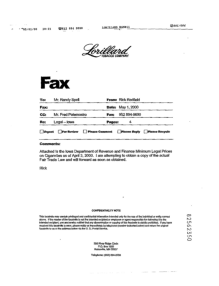

In [19]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[20]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [20]:
print(get_y_fn(img_f))

dataset/Labels/test/82562350.png


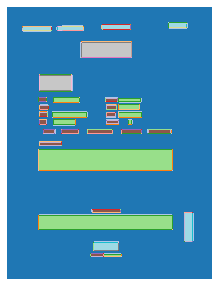

In [21]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [22]:
np.unique(np.array(mask))

array([0, 1, 2, 3, 4], dtype=uint8)

In [23]:
size = (1000,754)
bs =  4

In [24]:
codes

array(['Background', 'answer', 'question', 'header', 'other'],
      dtype='<U10')

In [25]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [26]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
# dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [ ]:
#x,mask=dls.one_batch()

# Deeplab

In [27]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50",
                                 metrics=[DiceMulti],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Recorder

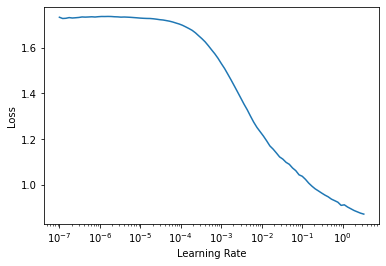

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice_multi,time
0,1.435707,1.341149,0.326982,00:21
1,0.998091,0.643998,0.471891,00:23
2,0.665276,0.402264,0.502721,00:23
3,0.489680,0.399445,0.499525,00:22
4,0.398268,0.440519,0.505497,00:23
5,0.348553,0.345728,0.560601,00:23
6,0.312290,0.337227,0.541965,00:25
7,0.289185,0.503102,0.432977,00:29
8,0.281674,0.354249,0.537164,00:23
9,0.271558,0.353143,0.589348,00:22


Better model found at epoch 0 with valid_loss value: 1.3411486148834229.


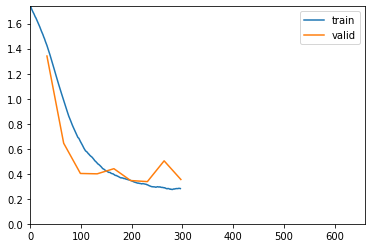

Better model found at epoch 1 with valid_loss value: 0.6439977288246155.
Better model found at epoch 2 with valid_loss value: 0.4022638499736786.
Better model found at epoch 3 with valid_loss value: 0.3994450271129608.
Better model found at epoch 5 with valid_loss value: 0.34572848677635193.
Better model found at epoch 6 with valid_loss value: 0.33722659945487976.
No improvement since epoch 6: early stopping


In [ ]:
fname="deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [ ]:
learn.load("deeplab-before-unfreeze")
learn.unfreeze()
# learn.lr_find() # find learning rate
# learn.recorder # plot learning rate graph

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,dice_multi,time
0,0.271770,0.324075,0.553360,00:23
1,0.266027,0.317127,0.564439,00:24
2,0.260722,0.321250,0.558757,00:22
3,0.257369,0.320423,0.558239,00:22
4,0.263444,0.320427,0.559812,00:23


Better model found at epoch 0 with valid_loss value: 0.32407456636428833.


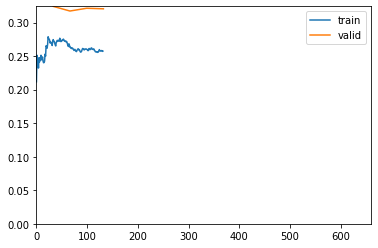

Better model found at epoch 1 with valid_loss value: 0.31712719798088074.
No improvement since epoch 1: early stopping


In [ ]:
fname="deeplab-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [ ]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("deeplab.pth")

In [ ]:
def ParentSplitter(x):
    return Path(x).parent.name=='test'

In [ ]:
dbtest = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
testDLS = dbtest.dataloaders(path_images,bs=bs)

learn.dls = testDLS

learn.validate()

(#2) [0.2769782543182373,0.6045280363024486]

In [ ]:
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [ ]:
import PIL
import cv2

In [ ]:
model = torch.jit.load("deeplab.pth")
model = model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=DeepLabV3Plus
  (backbone): RecursiveScriptModule(
    original_name=ResNetV1
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BottleneckV1b
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential

In [ ]:
for imPath in get_image_files('dataset/Images/test'):
    img = cv2.imread(str(imPath))
    img = Image.fromarray(img)
    image = transforms.Resize((1000,754))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask=np.reshape(mask,(1000,754))
    img = Image.fromarray(mask.astype('uint8'))
    img.save('deeplabPreds/'+imPath.name)